In [1]:
# For importing the graph data from the NeuroData Graph Database
import sys
sys.path.append('../')

# Import the necessary libraries
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from animal_helpers import *
from MRI_preprocessing.py_helpers.general_helpers import *

# Define the main data path
root_path = "C:\\Users\\shahi\\OneDrive - Imperial College London\\Documents\\imperial\\Dissertation\\Animal_Data\\NeuroData_Graph_Database"

### **Glob-ing and Creating Graphs**

In [2]:
# Grab all the graph files
graph_files = glob_files(root_path, "graphml")

# Create dictionary of animal graphs
animal_graphs = {}
# For every globbed file
for file in graph_files:
    # 
    animal = file.split("\\")[-2]

    file_name = file.split("\\")[-1].split(".")
    file_name.remove('graphml')
    file_name = ("_").join(file_name)

    if animal not in animal_graphs:
        animal_graphs[animal] = []
    animal_graphs[animal].append({"Name": file_name, "Filepath": file})

print(animal_graphs.keys())

dict_keys(['Cat', 'Fly', 'Mouse', 'Rats', 'Rhesus', 'Worm'])


In [3]:
# Notice that for every graph, there may be one or more ways of defining the
# edge strength. Because of this, I'll just hard-code the exact edge attribute 
# name that defines strength for each file of each animal, and it can be changed
# later if needed

# Read in the graphs using networkX
animal_graphs_nx = {}
for animal in animal_graphs.keys():
    # Create new list for the animal
    animal_graphs_nx[animal] = []
    # For each of the file dictionaries for each animal
    for idx, file_dict in enumerate(animal_graphs[animal]):
        # Depending on file_name, append the correct edge attribute name
        edge_attributes = define_edge_attributes(file_dict["Name"])
        animal_graphs_nx[animal].append({'Name': file_dict["Name"],
                                         'Graph': nx.read_graphml(file_dict["Filepath"], force_multigraph=True), 
                                         'Edge_Attributes': edge_attributes})

# Print the number of graphs for each animal
for animal in animal_graphs_nx.keys():
    print("{animal}: {num_graphs}".format(animal=animal, num_graphs=len(animal_graphs_nx[animal])))

Cat: 1
Fly: 1
Mouse: 4
Rats: 3
Rhesus: 4
Worm: 4


In [4]:
# Print edge attributes for each animal
for animal in animal_graphs_nx.keys():
    print("-"*50)
    print("{animal}:".format(animal=animal), end=" ")
    for graph_dict in animal_graphs_nx[animal]:
        print("\t{graph_name}: {edge_attributes}".format(graph_name=graph_dict["Name"], edge_attributes=graph_dict["Edge_Attributes"]))

--------------------------------------------------
Cat: 	mixed_species_brain_1: []
--------------------------------------------------
Fly: 	drosophila_medulla_1: ['post.z', 'post.x', 'post.y', 'pre.x', 'pre.y', 'pre.z']
--------------------------------------------------
Mouse: 	mouse_brain_1: ['w_contra_weight', 'pvalue_contra_weight', 'w_ipsi_weight', 'pvalue_ipsi_weight']
	mouse_retina_1: ['y', 'x', 'z', 'area']
	mouse_visual_cortex_1: ['weight']
	mouse_visual_cortex_2: ['weight']
--------------------------------------------------
Rats: 	rattus_norvegicus_brain_1: ['weight']
	rattus_norvegicus_brain_2: ['weight']
	rattus_norvegicus_brain_3: ['weight']
--------------------------------------------------
Rhesus: 	rhesus_brain_1: []
	rhesus_brain_2: ['SLN_perc', 'Dist_mm']
	rhesus_cerebral_cortex_1: ['FLNe']
	rhesus_interareal_cortical_network_2: ['weight']
--------------------------------------------------
Worm: 	c_elegans_herm_pharynx_1: ['weight']
	c_elegans_neural_male_1: ['electrica

### **Saving Data as CSV Files**

In [5]:
# Save the data as CSV file, to be viewed and plotted
for animal in animal_graphs_nx.keys():

    print("-"*50)
    print("{animal}:".format(animal=animal), end=" ")
    # Create folder for every animal
    animal_folder = os.path.join("matrices", animal)
    if not os.path.exists(animal_folder):
        os.makedirs(animal_folder)

    # For each graph
    for graph_dict in animal_graphs_nx[animal]:
        print("\t{graph_name}".format(graph_name=graph_dict["Name"]))
        # If there are more than one attributes, then create a separate file for each
        if len(graph_dict["Edge_Attributes"]) > 1:
            # For each edge attribute
            for edge_attribute in graph_dict["Edge_Attributes"]:
                print("Edge Attribute: {edge_attribute}".format(edge_attribute=edge_attribute))
                # Create the main file name
                file_name = os.path.join(animal_folder, "{animal}_{graph_name}_{edge_attribute}.csv".format(animal=animal, graph_name=graph_dict["Name"], edge_attribute=edge_attribute))
                # Create the CSV file
                np.savetxt(file_name, nx.to_numpy_array(graph_dict["Graph"], weight=edge_attribute), delimiter=",")
        # Otherwise, just create one file
        else:
            # Create the main file name
            file_name = os.path.join(animal_folder, "{animal}_{graph_name}.csv".format(animal=animal, graph_name=graph_dict["Name"]))
            # Create the CSV file
            np.savetxt(file_name, nx.to_numpy_array(graph_dict["Graph"]), delimiter=",")        

--------------------------------------------------
Cat: 	mixed_species_brain_1
--------------------------------------------------
Fly: 	drosophila_medulla_1
Edge Attribute: post.z
Edge Attribute: post.x
Edge Attribute: post.y
Edge Attribute: pre.x
Edge Attribute: pre.y
Edge Attribute: pre.z
--------------------------------------------------
Mouse: 	mouse_brain_1
Edge Attribute: w_contra_weight
Edge Attribute: pvalue_contra_weight
Edge Attribute: w_ipsi_weight
Edge Attribute: pvalue_ipsi_weight
	mouse_retina_1
Edge Attribute: y
Edge Attribute: x
Edge Attribute: z
Edge Attribute: area
	mouse_visual_cortex_1
	mouse_visual_cortex_2
--------------------------------------------------
Rats: 	rattus_norvegicus_brain_1
	rattus_norvegicus_brain_2
	rattus_norvegicus_brain_3
--------------------------------------------------
Rhesus: 	rhesus_brain_1
	rhesus_brain_2
Edge Attribute: SLN_perc
Edge Attribute: Dist_mm
	rhesus_cerebral_cortex_1
	rhesus_interareal_cortical_network_2
----------------------

### **Plot the Graphs**

In [6]:
# Load the csv files we just saved
csv_files = glob_files(os.path.join(os.getcwd(), "matrices"), "csv")

# Create dictionary of csv files according to animal
csv_files_dict = {}
for file in csv_files:
    # Grab the animal name
    animal_name = file.split("\\")[-2]
    # If the animal is not in the dictionary, add it
    if animal_name not in csv_files_dict:
        csv_files_dict[animal_name] = []
    # Append the file to the animal
    csv_files_dict[animal_name].append({'Name': file.split("\\")[-1], 
                                        'Filepath': file, 
                                        'Numpy': np.genfromtxt(file, delimiter=',')})

# Print the number of csv files
for key, value in csv_files_dict.items():
    print("Key: {}, Length: {}".format(key, len(value)))

Key: Cat, Length: 1
Key: Fly, Length: 6
Key: Mouse, Length: 10
Key: Rats, Length: 3
Key: Rhesus, Length: 5
Key: Worm, Length: 5


In [ ]:
# MAKE HISTOGRAM OF MATRICES BC PROBLEM MAY BE THAT YOU GOT BIG NUMBER IN MATRIX MESSING IT UP SO CHECK
# OR REMOVE TOP AND BOTTOM 5% OF VALUES OUTLIER DETECTION

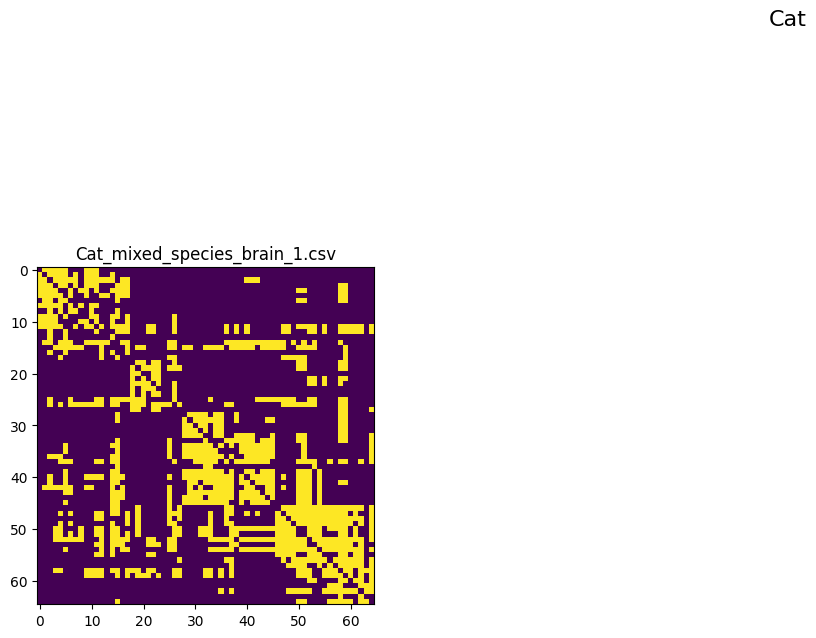

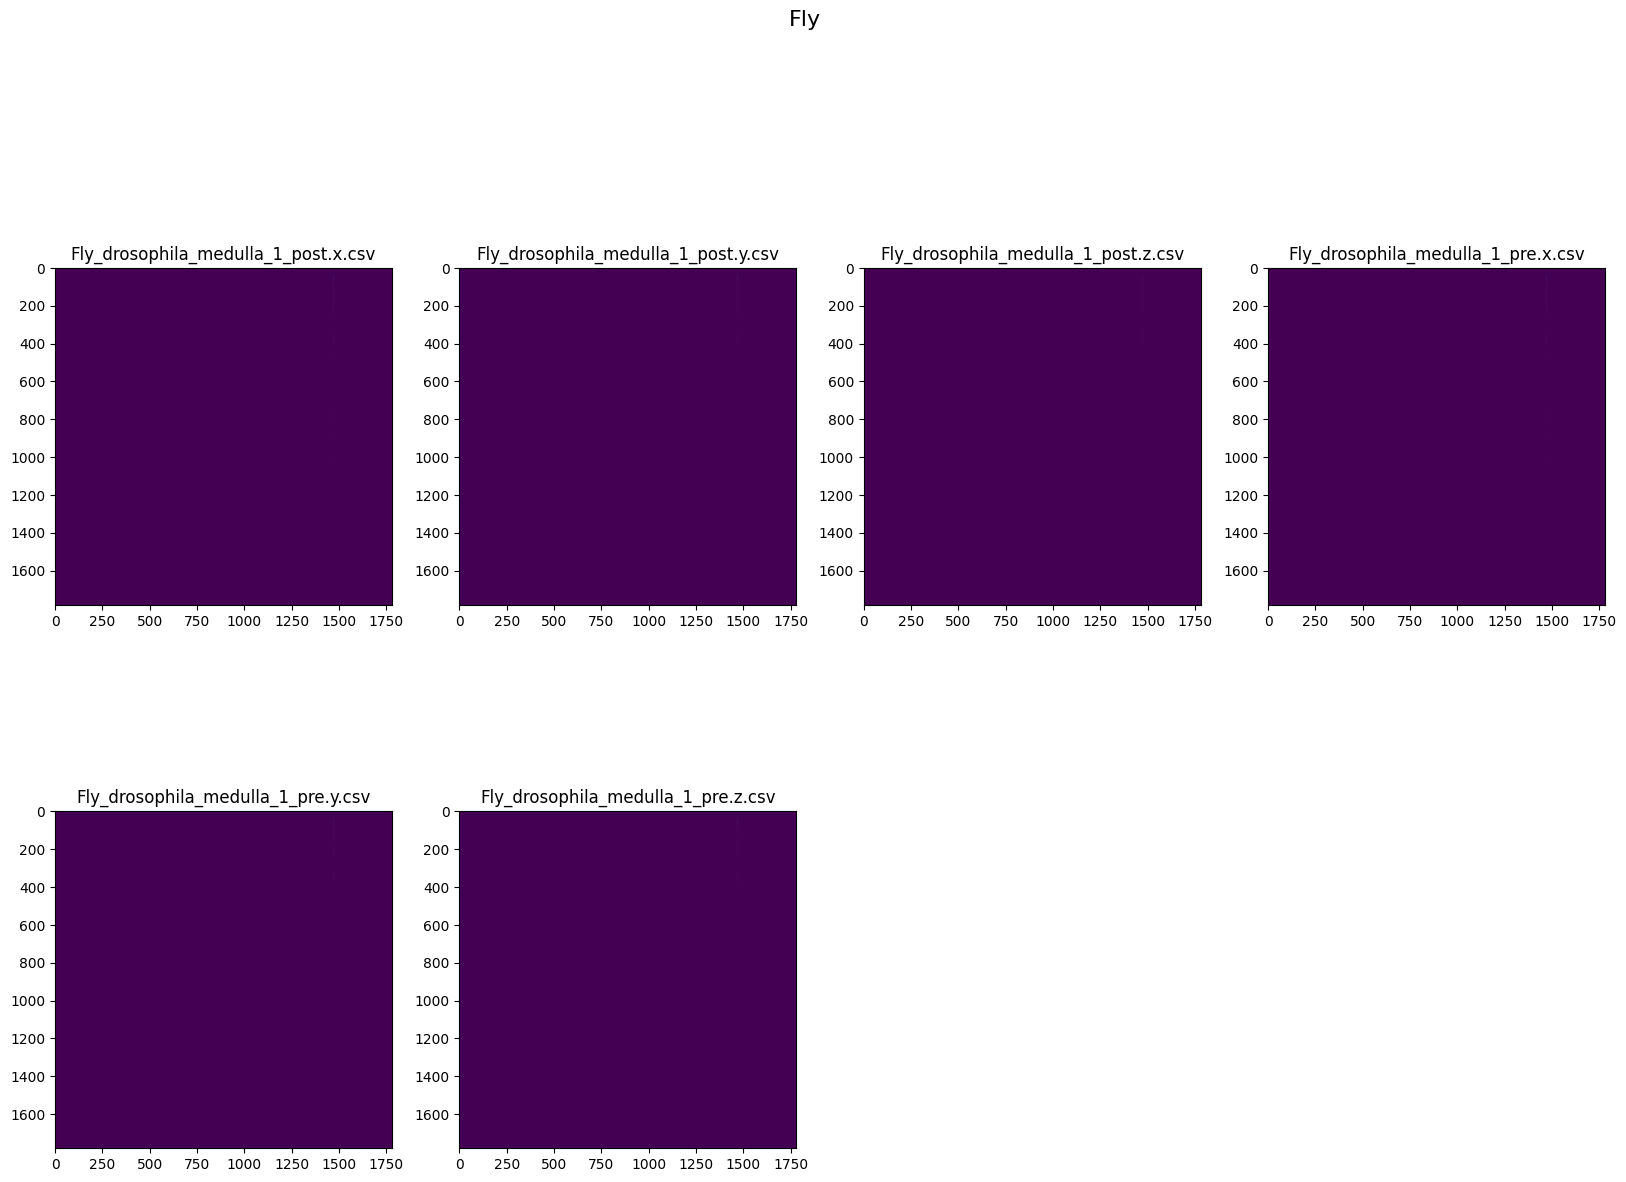

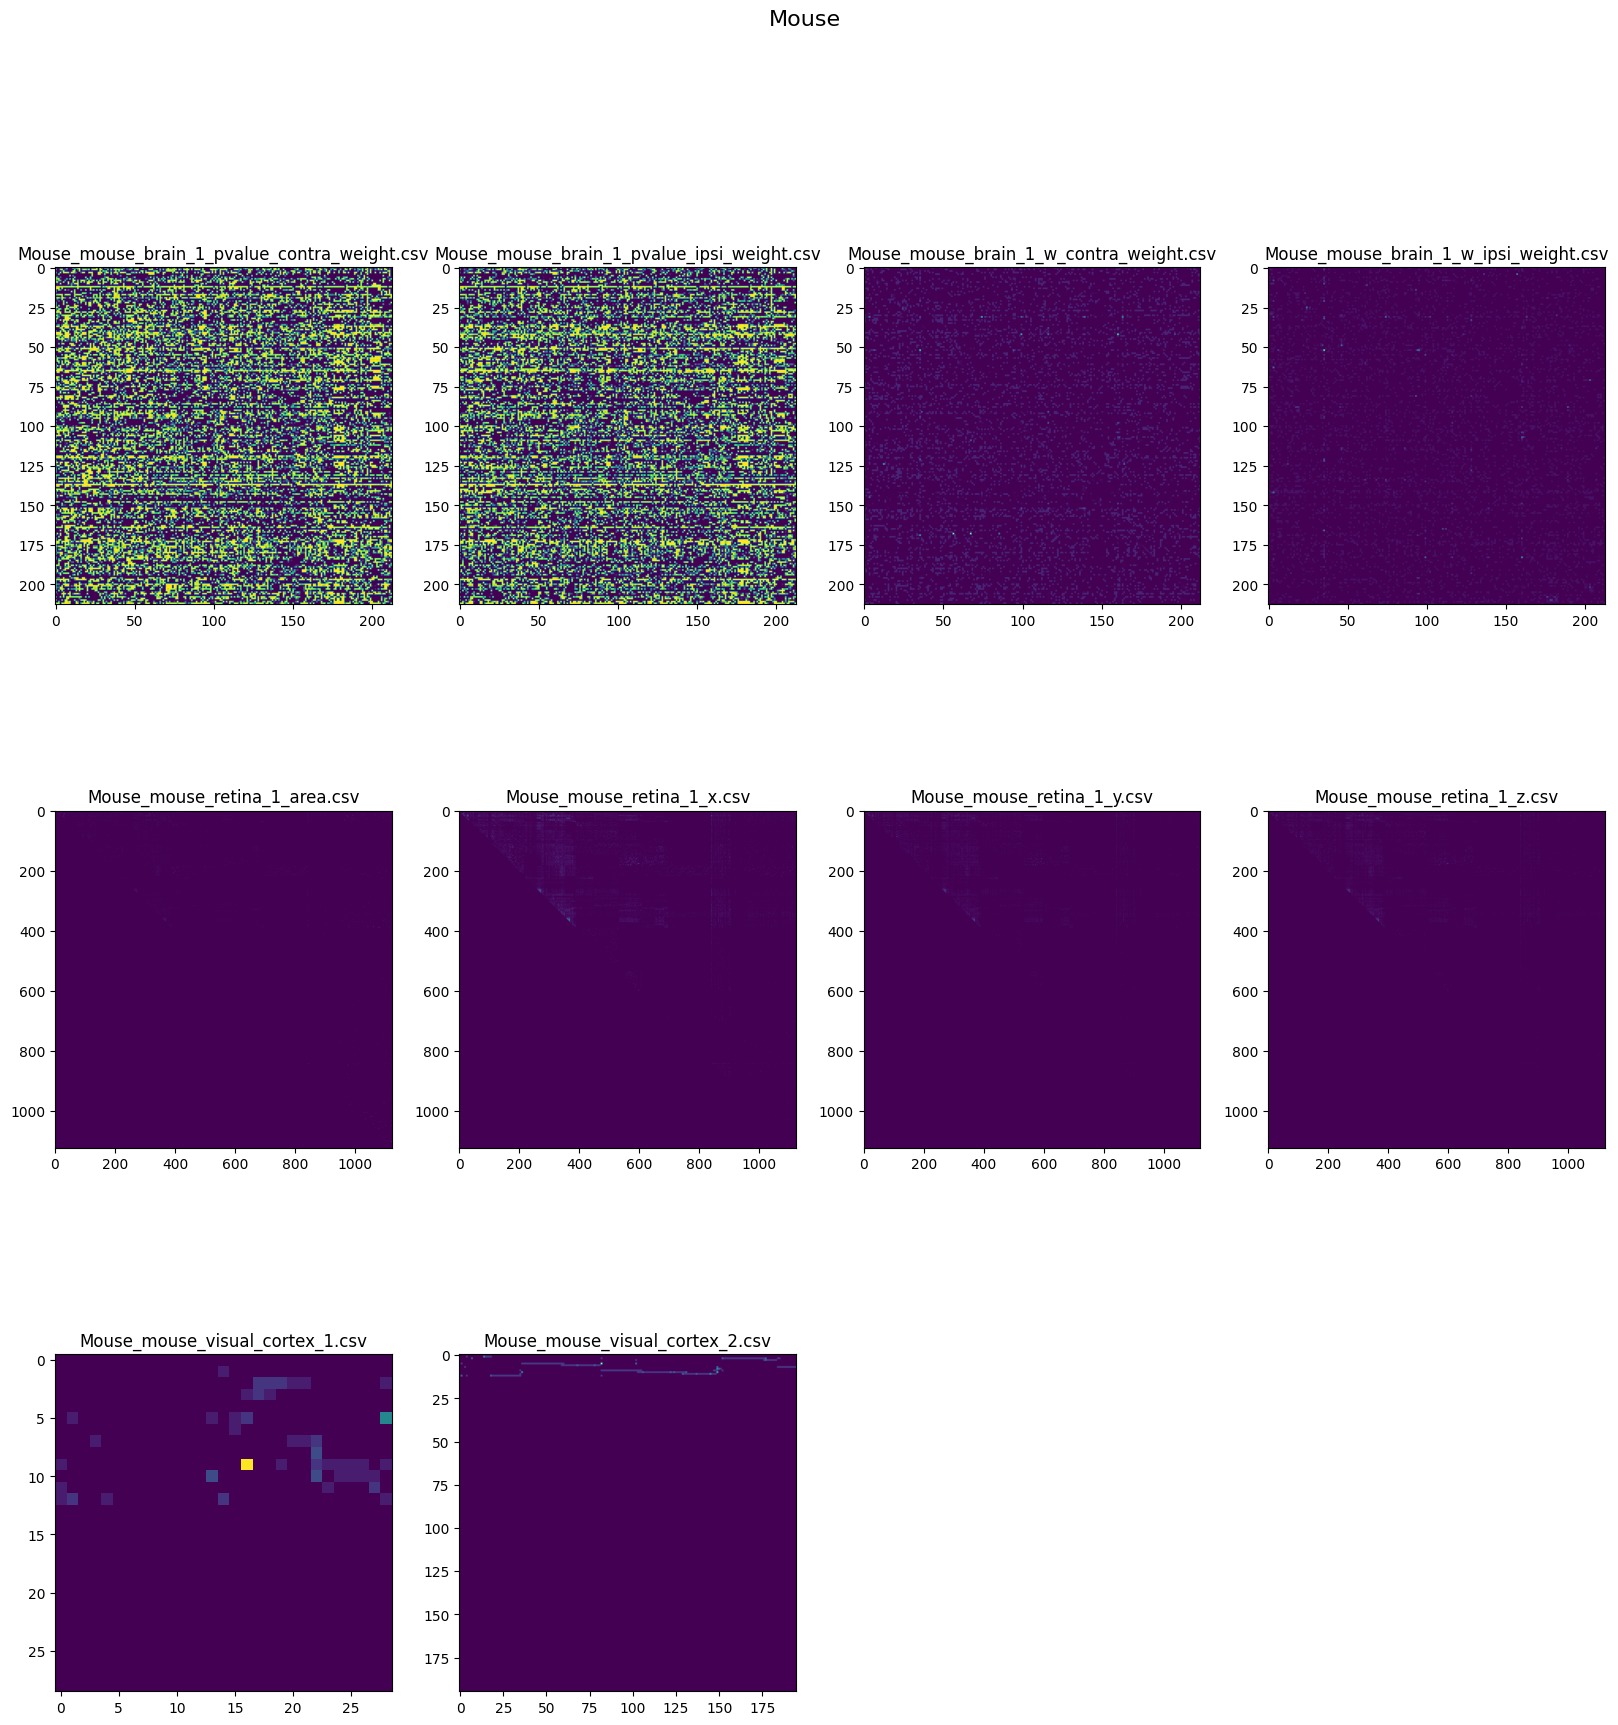

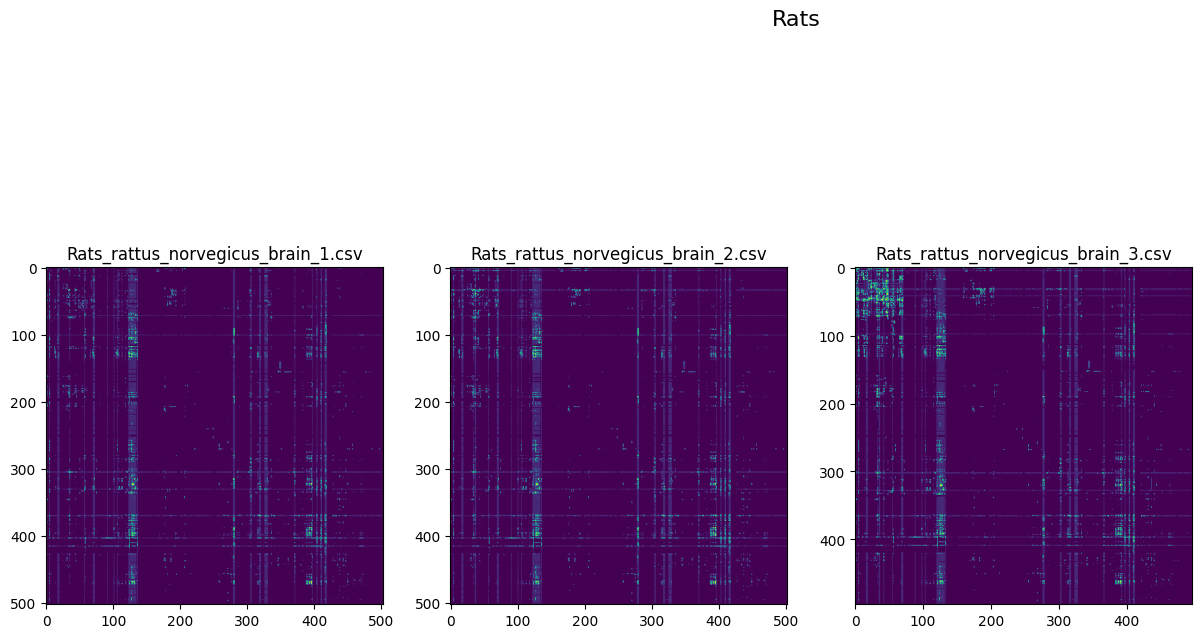

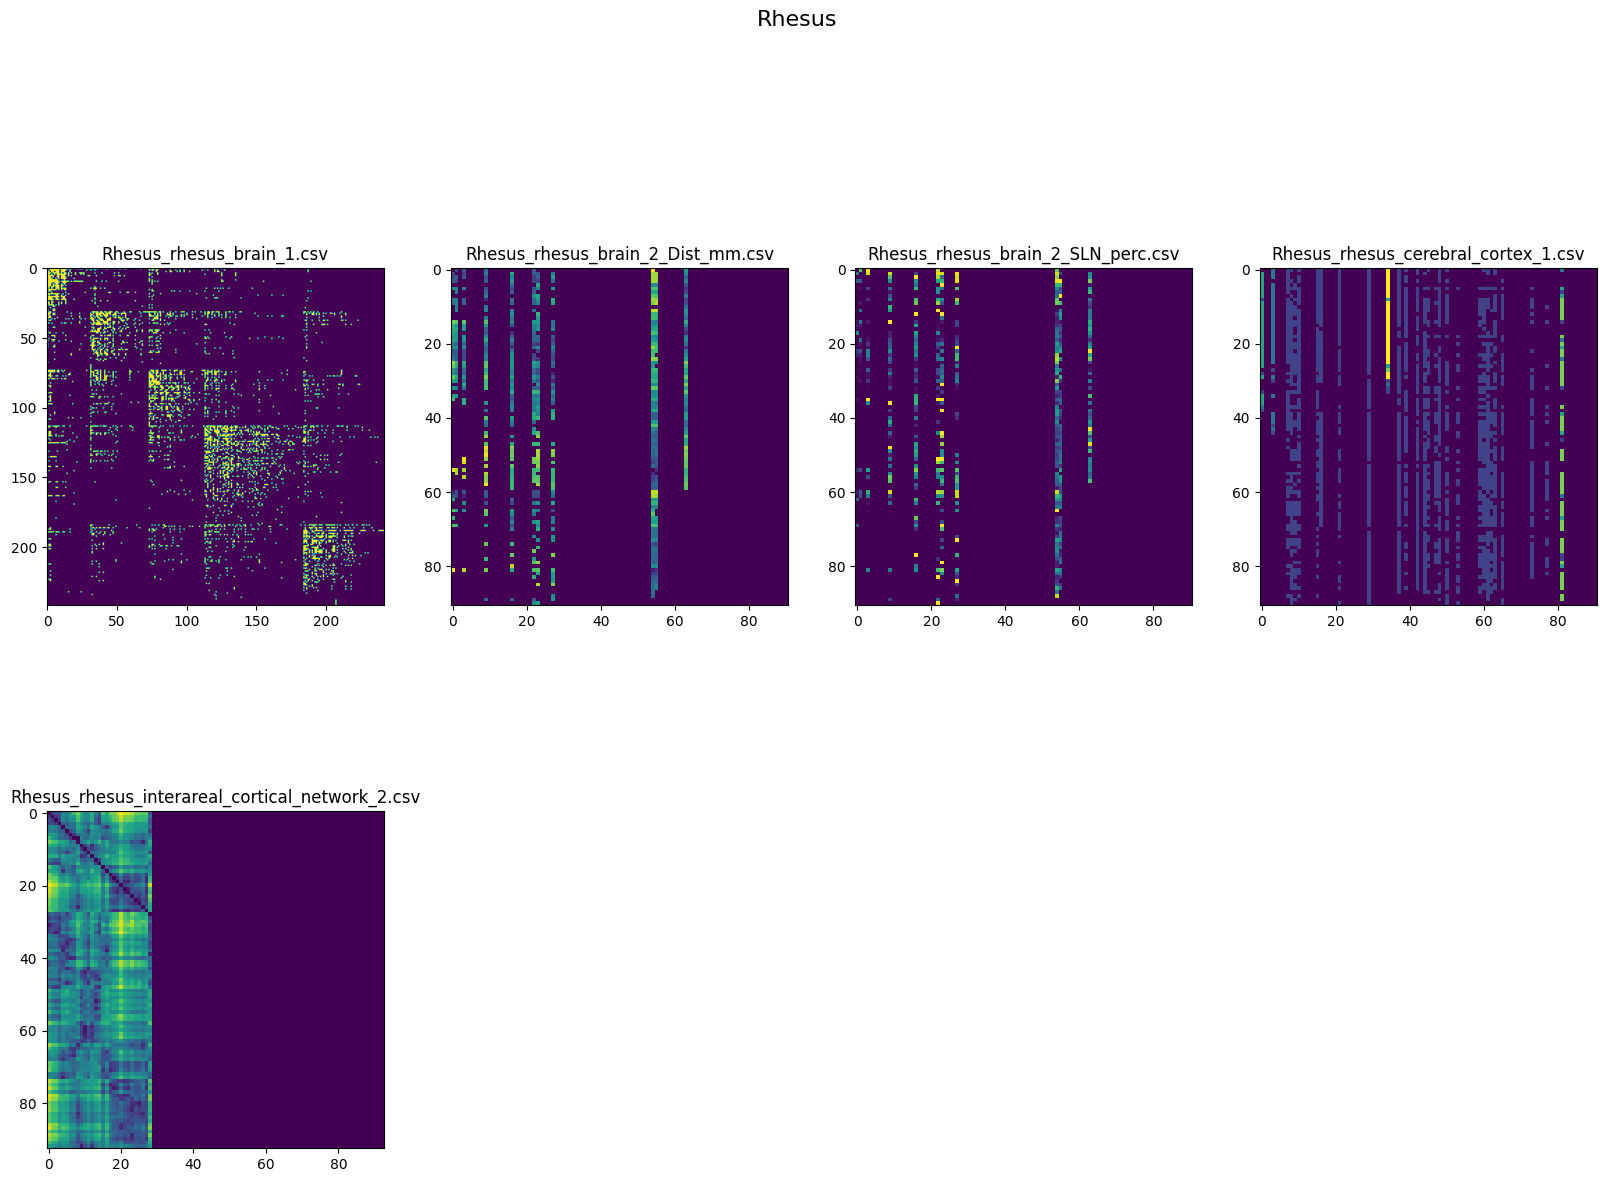

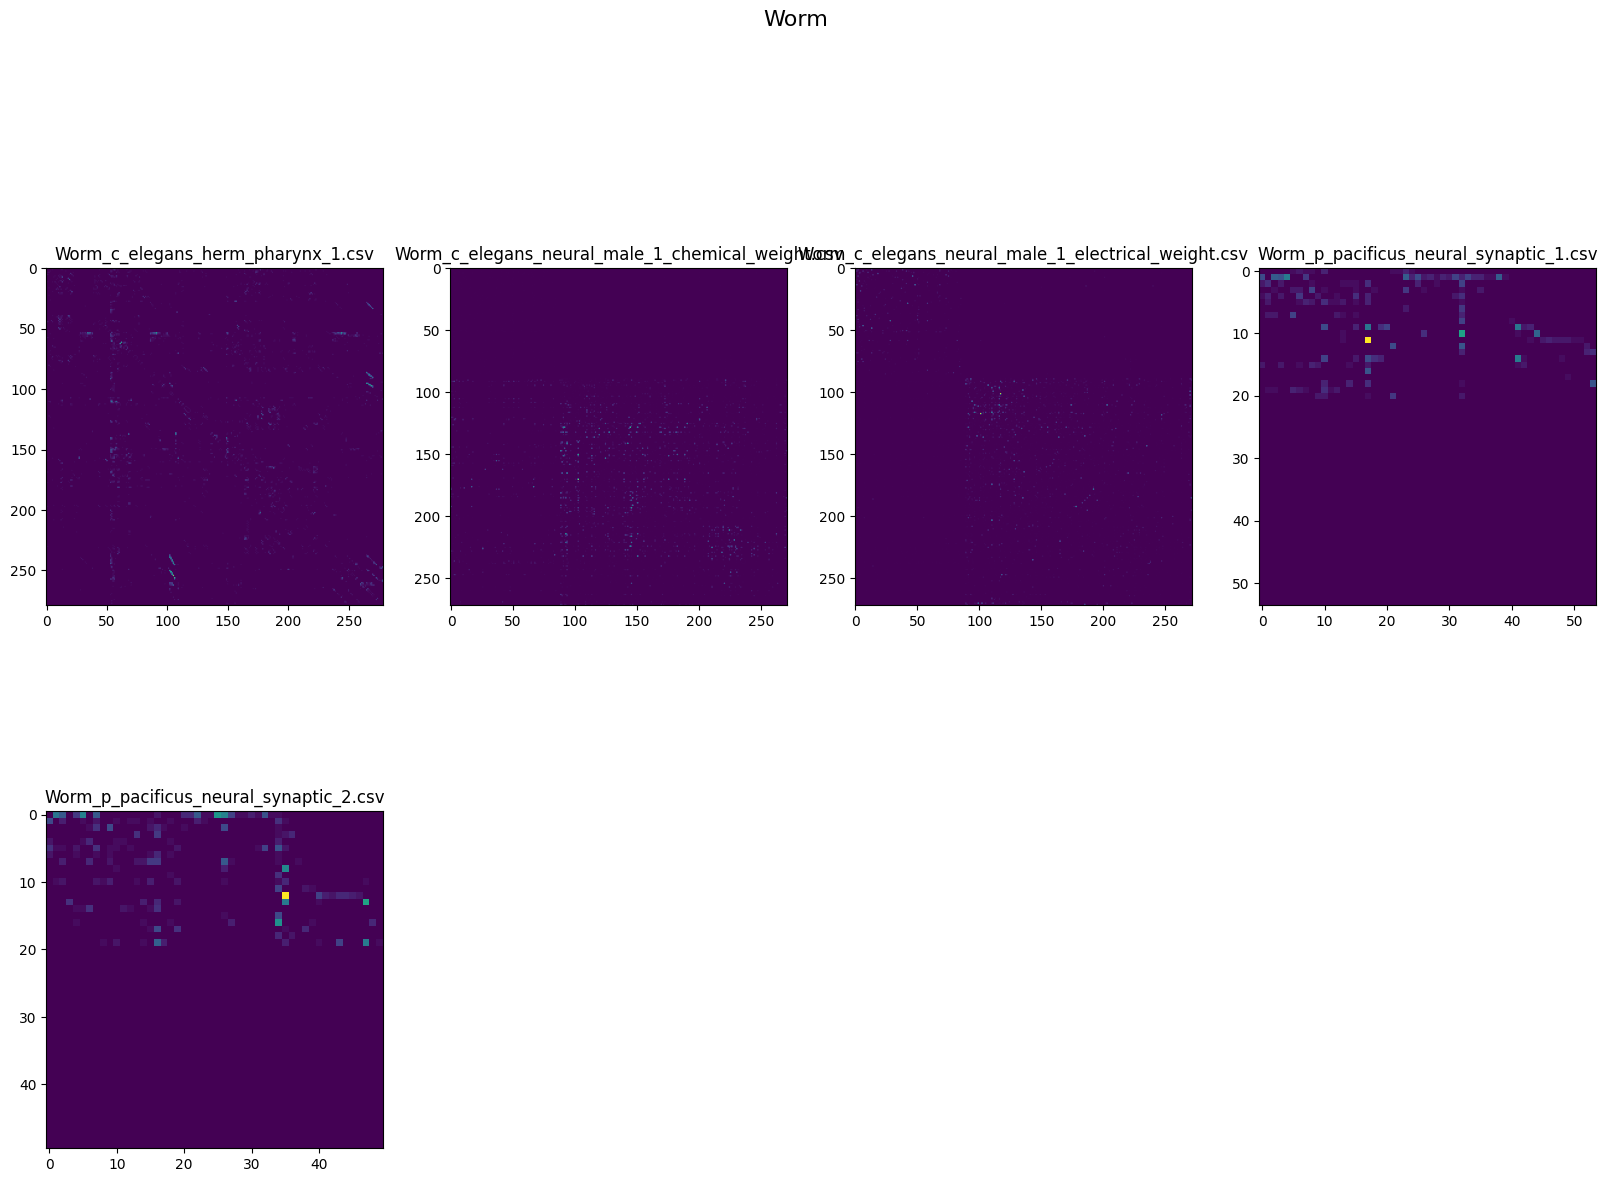

In [7]:
# Plot the numpy arrays using matplotlib
for animal in csv_files_dict.keys():
    # Create the main figure
    fig = plt.figure(figsize=(20, 20))
    # Create the main title
    fig.suptitle("{animal}".format(animal=animal), fontsize=16)
    # For each csv file
    for idx, csv_file in enumerate(csv_files_dict[animal]):
        # Create the subplot
        ax = fig.add_subplot(3, 4, idx+1)
        # Set the title
        ax.set_title(csv_file["Name"])
        # Plot the numpy array
        ax.imshow(csv_file["Numpy"])
    # Show the figure
    plt.show()

In [8]:
allen_mouse = "C:\\Users\\shahi\\OneDrive - Imperial College London\\Documents\\imperial\\Dissertation\\Animal_Data\\General_Sources\\Mice\\Allen_Mouse\\actual_matrices"

# Open the csv files
csv_files = glob_files(allen_mouse, "csv")

# Create dictionary of csv files according to animal
csv_files_dict = {}
for file in csv_files:
    # Grab the animal name
    animal_name = file.split("\\")[-2]
    # If the animal is not in the dictionary, add it
    if animal_name not in csv_files_dict:
        csv_files_dict[animal_name] = []
    # Append the file to the animal
    csv_files_dict[animal_name].append({'Name': file.split("\\")[-1], 
                                        'Filepath': file, 
                                        'Numpy': np.genfromtxt(file, delimiter=',')})


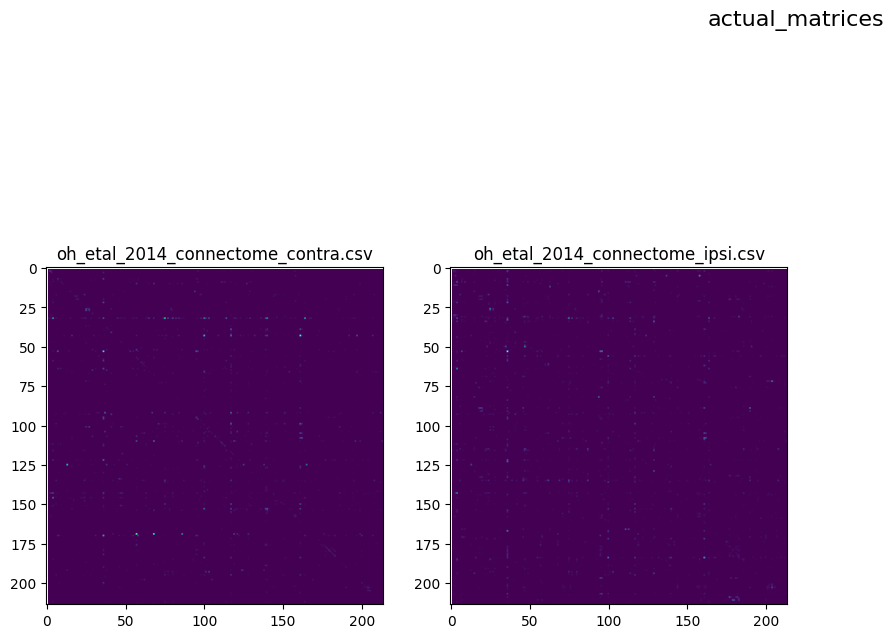

In [9]:
# Plot the numpy arrays using matplotlib
for animal in csv_files_dict.keys():
    # Create the main figure
    fig = plt.figure(figsize=(20, 20))
    # Create the main title
    fig.suptitle("{animal}".format(animal=animal), fontsize=16)
    # For each csv file
    for idx, csv_file in enumerate(csv_files_dict[animal]):
        # Create the subplot
        ax = fig.add_subplot(3, 4, idx+1)
        # Set the title
        ax.set_title(csv_file["Name"])
        # Plot the numpy array
        ax.imshow(csv_file["Numpy"])
    # Show the figure
    plt.show()

KeyboardInterrupt: 

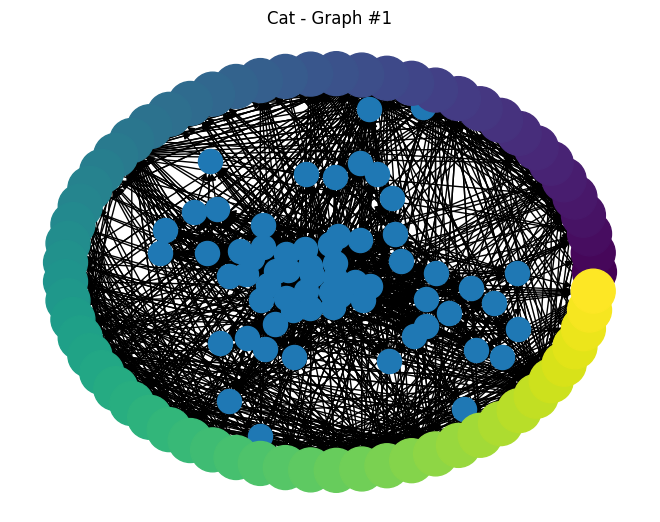

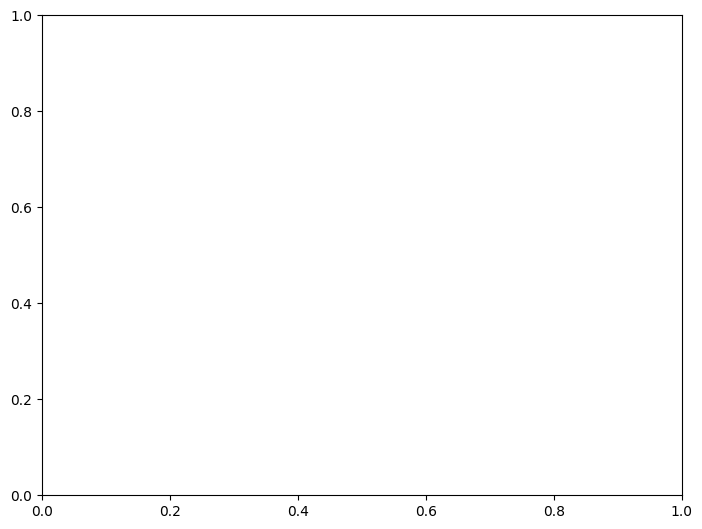

In [7]:
# Save the graphs as plots
# For each animal
for animal in animal_graphs_nx.keys():
    # For each graph
    for idx, graph in enumerate(animal_graphs_nx[animal]):
        print("Graph #{idx}".format(idx=idx + 1))

        # Defining the node colors
        colors = np.linspace(0, 1, len(graph.nodes))
        # Defining the node positions
        pos = nx.random_layout(graph)
        nx.draw_networkx_nodes(graph, pos, node_color=colors, node_size=1000)

        # Edges
        labels = nx.get_edge_attributes(graph, "weight")
        nx.draw_networkx_edges(graph, pos, arrows=True)
        nx.draw(
            graph, pos, node_size=1000, node_color=colors
        )  # draws directed graph, nx.draw(G, arrows=False) for removing arrows

        # Draw node labels and change font size
        node_labels = nx.get_node_attributes(graph, "label")
        nx.draw_networkx_labels(graph, pos, labels=node_labels, font_size=10)

        # Draw edge labels
        edge_labels = nx.get_edge_attributes(graph, "type")
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

        plt.title("{animal} - Graph #{idx}".format(animal=animal, idx=idx + 1))

plt.show()

In [30]:
# Print the number of graphs for each animal
for animal in animal_graphs_nx.keys():
    print("-"*50)
    # For each graph for each animal, print the number of nodes and edges
    for graph in animal_graphs_nx[animal]:
        print("{animal}: {num_nodes} nodes, {num_edges} edges".format(animal=animal, num_nodes=graph.number_of_nodes(), num_edges=graph.number_of_edges()))

--------------------------------------------------
Cat: 65 nodes, 1139 edges
--------------------------------------------------
Fly: 1781 nodes, 33641 edges
--------------------------------------------------
Mouse: 213 nodes, 21807 edges
Mouse: 1123 nodes, 577350 edges
Mouse: 29 nodes, 44 edges
Mouse: 195 nodes, 214 edges
--------------------------------------------------
Rats: 503 nodes, 27667 edges
Rats: 503 nodes, 30088 edges
Rats: 496 nodes, 33020 edges
--------------------------------------------------
Rhesus: 242 nodes, 4090 edges
Rhesus: 91 nodes, 628 edges
Rhesus: 91 nodes, 1989 edges
Rhesus: 93 nodes, 2667 edges
--------------------------------------------------
Worm: 279 nodes, 3225 edges
Worm: 272 nodes, 4451 edges
Worm: 54 nodes, 511 edges
Worm: 50 nodes, 611 edges


In [34]:
# Create the adjacency matrices for each animal
animal_adj_matrices = {}
# For each animal
for animal in animal_graphs_nx.keys():
    animal_adj_matrices[animal] = []
    # For each graph for each animal
    for graph in animal_graphs_nx[animal]:
        # Append the adjacency matrix to the list
        animal_adj_matrices[animal].append(nx.adjacency_matrix(graph).todense())
    
# Print the shape of the adjacency matrices
for animal in animal_adj_matrices.keys():
    print("-"*50)
    # For each graph for each animal
    for idx, graph in enumerate(animal_adj_matrices[animal]):
        print("{animal} - Graph #{idx}: {shape}".format(animal=animal, idx=idx + 1, shape=graph.shape))

--------------------------------------------------
Cat - Graph #1: (65, 65)
--------------------------------------------------
Fly - Graph #1: (1781, 1781)
--------------------------------------------------
Mouse - Graph #1: (213, 213)
Mouse - Graph #2: (1123, 1123)
Mouse - Graph #3: (29, 29)
Mouse - Graph #4: (195, 195)
--------------------------------------------------
Rats - Graph #1: (503, 503)
Rats - Graph #2: (503, 503)
Rats - Graph #3: (496, 496)
--------------------------------------------------
Rhesus - Graph #1: (242, 242)
Rhesus - Graph #2: (91, 91)
Rhesus - Graph #3: (91, 91)
Rhesus - Graph #4: (93, 93)
--------------------------------------------------
Worm - Graph #1: (279, 279)
Worm - Graph #2: (272, 272)
Worm - Graph #3: (54, 54)
Worm - Graph #4: (50, 50)


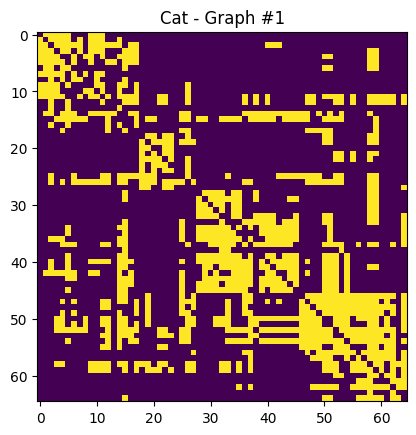

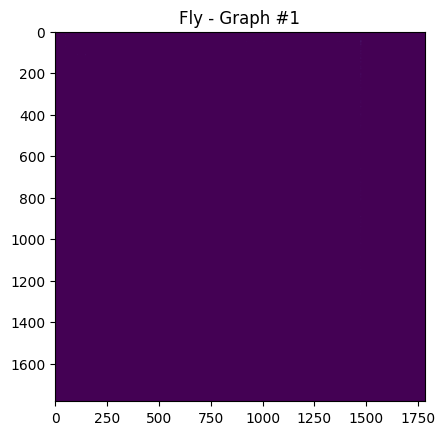

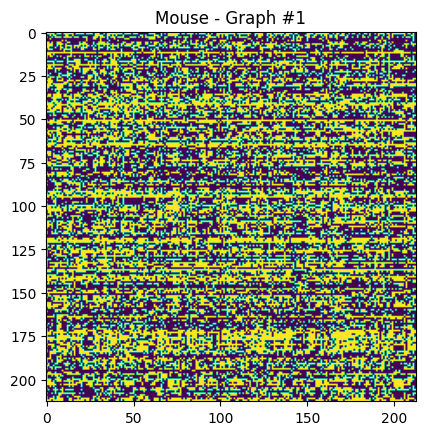

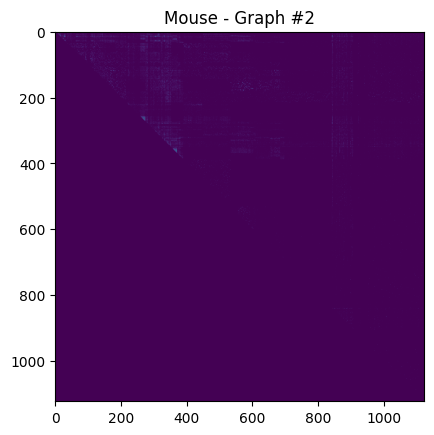

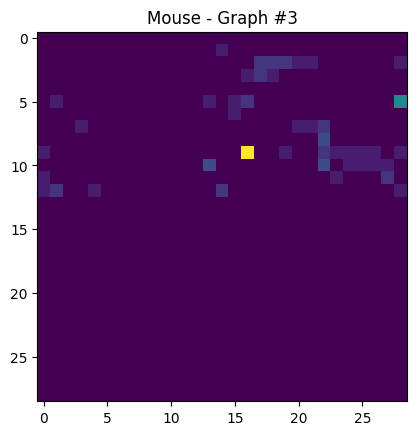

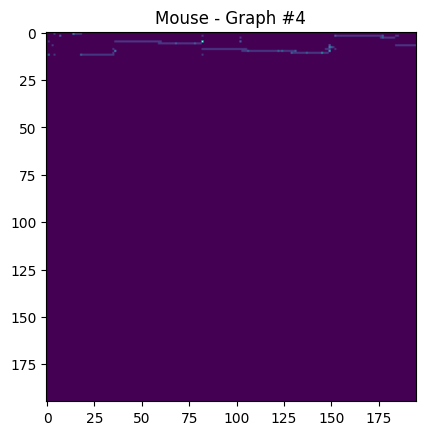

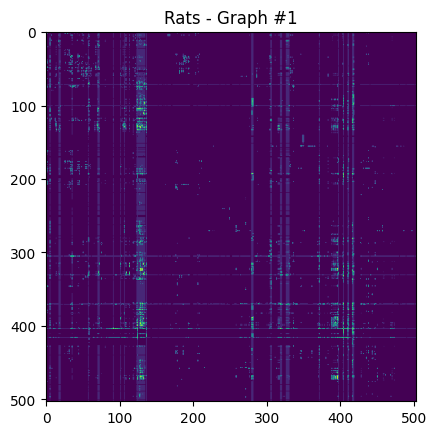

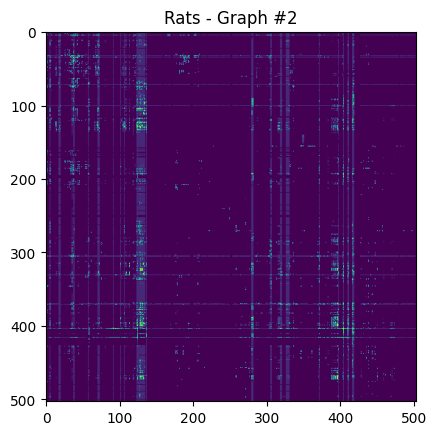

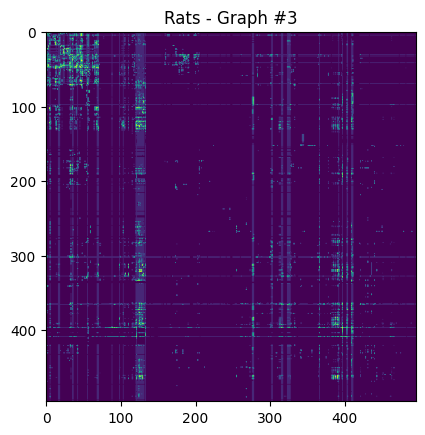

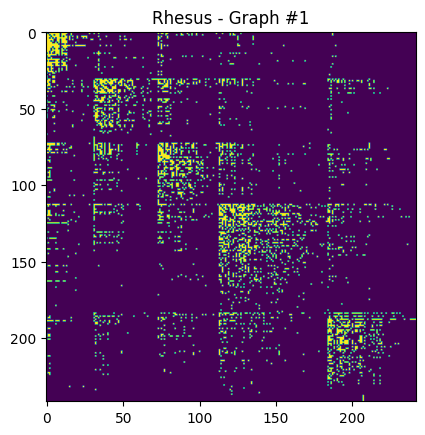

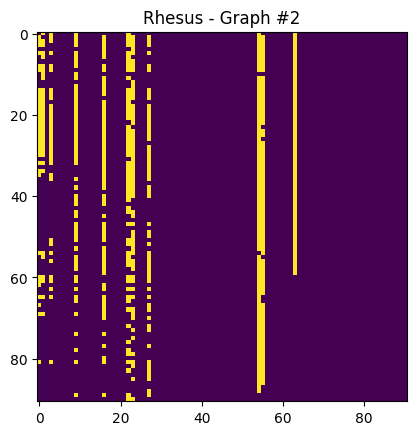

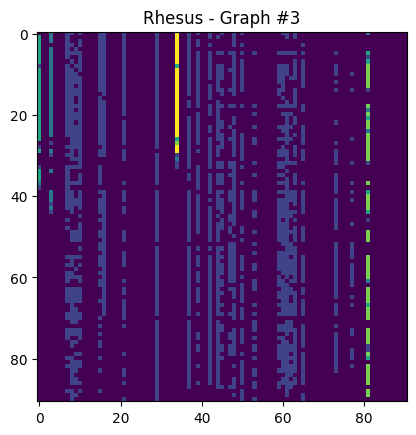

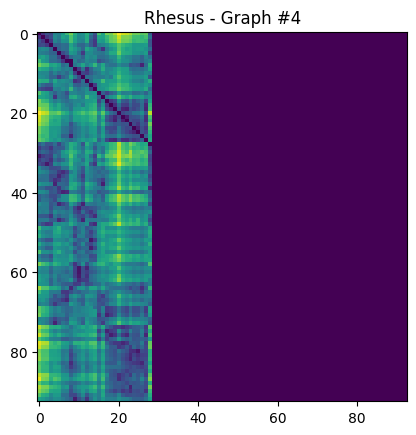

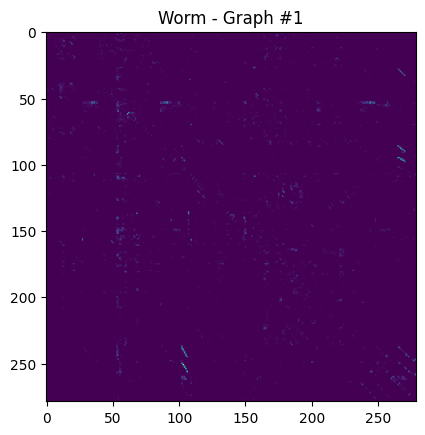

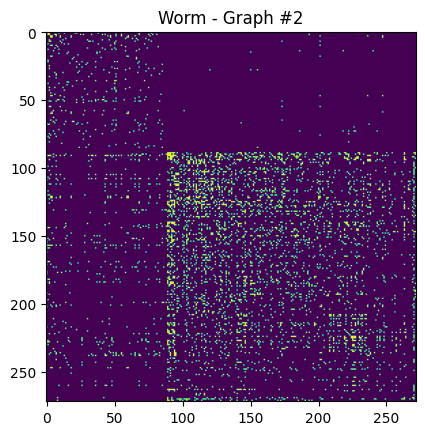

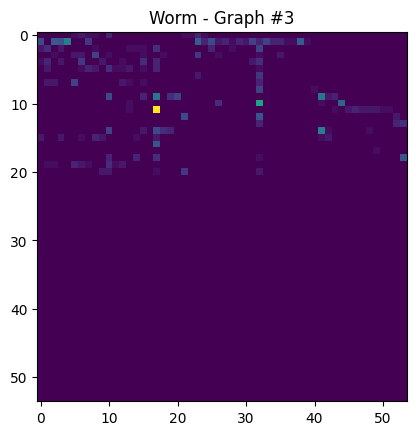

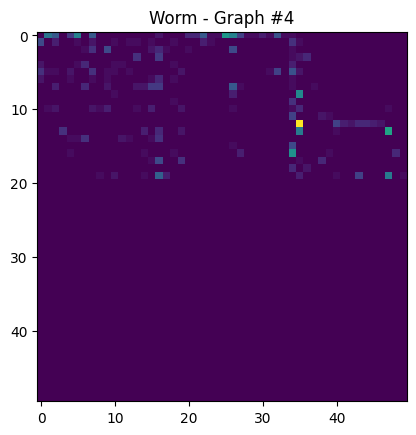

In [35]:
# Plot the adjacency matrices
for animal in animal_adj_matrices:
    # For each graph for each animal
    for idx, graph in enumerate(animal_adj_matrices[animal]):
        plt.figure()
        plt.title("{animal} - Graph #{idx}".format(animal=animal, idx=idx + 1))
        plt.imshow(graph)
        plt.show()

In [38]:
# Save the adjacency matrices as csv files
for animal in animal_adj_matrices:
    # For each graph for each animal
    for idx, graph in enumerate(animal_adj_matrices[animal]):
        np.savetxt(os.path.join("matrices", "{animal}_graph_{idx}.csv".format(animal=animal, idx=idx + 1)), graph, delimiter=",")